In [33]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt
from interactions import traverse_all_paths, apply_rule, make_line, make_grid
from itertools import combinations_with_replacement
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import time

In [93]:
def fill_1d(line, counts, interval, val, count, rng, di):
    lower_bound = max(interval[0], rng[0])
    lower_bound = min(lower_bound, rng[-1])
    upper_bound = min(interval[1], rng[-1])
    upper_bound = max(upper_bound, rng[0])
    start_index = np.nonzero(rng - lower_bound >= 0)[0][0]
    end_index = np.nonzero(rng - upper_bound >= 0)[0][0]
    for i in range(start_index, end_index):
        line[i] += count * val
        counts[i] += count
    return

In [95]:
def new_make_line(values, interval_x, di, S):
    x_axis = np.arange(interval_x[0], interval_x[1] + di, di)
    line = np.zeros(x_axis.shape[0] - 1)
    counts = np.zeros(x_axis.shape[0] - 1)
    num_vars = len(S)
    ind = np.nonzero(S)[0][0]
    for v in values:
        x_inter = v[0:num_vars][ind]
        val, count = v[num_vars:]
        fill_1d(line, counts, x_inter, val, count, x_axis, di)
    for i in range(len(counts)):
        if(counts[i] == 0):
            counts[i] = 1
    return line/counts

In [105]:
def fill_2d(grid, counts, x_interval, y_interval, val, count, x_rng, y_rng, x_di, y_di):
    x_lower_bound = max(x_interval[0], x_rng[0])
    x_lower_bound = min(x_lower_bound, x_rng[-1])
    x_upper_bound = min(x_interval[1], x_rng[-1])
    x_upper_bound = max(x_upper_bound, x_rng[0])
    x_start_index = np.nonzero(x_rng - x_lower_bound >= 0)[0][0]
    x_end_index = np.nonzero(x_rng - x_upper_bound >= 0)[0][0]
    
    y_lower_bound = max(y_interval[0], y_rng[0])
    y_lower_bound = min(y_lower_bound, y_rng[-1])
    y_upper_bound = min(y_interval[1], y_rng[-1])
    y_upper_bound = max(y_upper_bound, y_rng[0])
    y_start_index = np.nonzero(y_rng - y_lower_bound >= 0)[0][0]
    y_end_index = np.nonzero(y_rng - y_upper_bound >= 0)[0][0]
    for y in range(y_start_index, y_end_index):
        for x in range(x_start_index, x_end_index):
            grid[y][x] += count * val
            counts[y][x] += count
    return

In [119]:
def new_make_grid(values, interval_x, interval_y, di_x, di_y, S):
    x_rng = np.arange(interval_x[0], interval_x[1] + di_x, di_x)
    y_rng = np.arange(interval_y[0], interval_y[1] + di_y, di_y)
    grid = np.zeros((len(y_rng) - 1, len(x_rng) - 1))
    counts = np.zeros((len(y_rng) - 1, len(x_rng) - 1))
    num_vars = len(S)
    for v in values:
        z = np.nonzero(S)
        x_ind = z[0][0]
        y_ind = z[0][1]
        x_inter = v[0:num_vars][x_ind]
        y_inter = v[0:num_vars][y_ind]
        xval, count = v[num_vars:]
        fill_2d(grid, counts, x_inter, y_inter, xval, count, x_rng, y_rng, di_x, di_y)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if counts[i][j] == 0:
                counts[i][j] = 1
    return grid/counts

In [61]:
X = np.random.uniform(0, 10, (10000, 2))
y = X[:, 0] * X[:, 1]
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

compute time 52.181201999999985


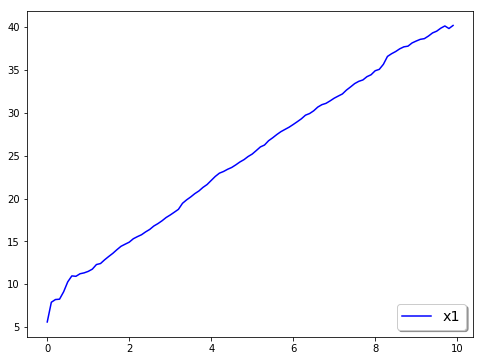

In [62]:
rng = (0, 10)
step = .1
S = [1, 0]
numtrees = 100
#####meta above this point#######
t_start = time.clock()
models = forest.estimators_
length = (rng[1] - rng[0])/(1.0 * step)
old_line = np.zeros(int(length))
index = np.nonzero(S)[0][0]
num_vars = len(S)
for model in models:
    vals = traverse_all_paths(model, X, y, S, continuous_y=True)
    old_line += make_line(vals, rng, step, index, num_vars)
old_line = old_line/(numtrees * 1.0)
t_end = time.clock()
print("compute time", t_end - t_start)
x_axis = np.arange(rng[0], rng[1], step)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, old_line, 'k', c='b', label="x1")
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()

compute time 32.18034


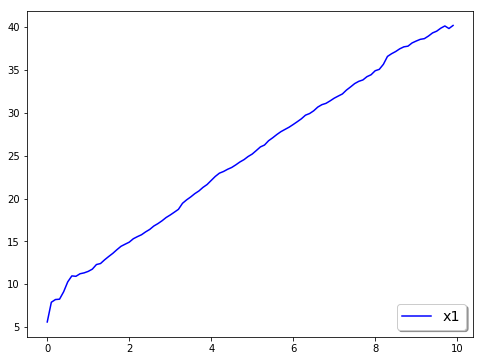

In [96]:
rng = (0, 10)
step = .1
S = [1, 0]
numtrees = 100
#####meta above this point#######
t_start = time.clock()
models = forest.estimators_
length = (rng[1] - rng[0])/(1.0 * step)
new_line = np.zeros(int(length))
for model in models:
    vals = traverse_all_paths(model, X, y, S, continuous_y=True)
    new_line += new_make_line(vals, rng, step, S)
new_line = new_line/(numtrees * 1.0)
t_end = time.clock()
print("compute time", t_end - t_start)
x_axis = np.arange(rng[0], rng[1], step)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, new_line, 'k', c='b', label="x1")
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()

In [97]:
print(new_line - old_line)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [89]:
print(new_line)
print(old_line)

[ 5.61626421  7.76496921  8.16069523  8.20860985  9.04313941 10.22863708
 10.91884297 10.90979111 11.20863559 11.32317504 11.48720019 11.75740654
 12.26422521 12.41667745 12.8271448  13.21546301 13.60230412 14.02914887
 14.42155696 14.66756027 14.9000055  15.30683344 15.5530683  15.77651421
 16.11177413 16.39420024 16.79525098 17.08029041 17.388789   17.78578614
 18.0829959  18.41214533 18.74301607 19.44839949 19.83708373 20.18921501
 20.56705244 20.88434365 21.31539668 21.63510306 22.11523346 22.57187651
 22.96159783 23.14902921 23.40028246 23.62325486 23.92562652 24.26672028
 24.53912487 24.90080903 25.19040578 25.59614019 26.06207029 26.24266874
 26.7428399  27.08530061 27.46390611 27.8012022  28.06403108 28.32334071
 28.64360172 28.96291122 29.30156549 29.72758405 29.92202145 30.20209604
 30.67559221 30.94625439 31.14056246 31.42162559 31.68417956 31.95337181
 32.23561607 32.67031647 33.00943836 33.41945087 33.68721792 33.84487265
 34.21648027 34.49217887 34.9049016  35.08270211 35

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


compute time 392.59391800000003


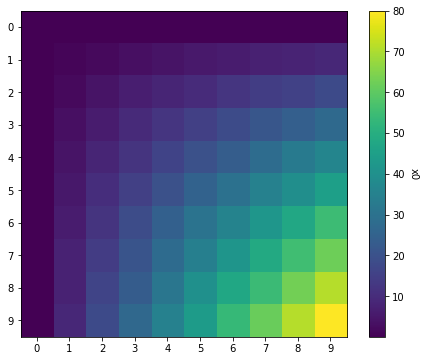

In [113]:
x_rng = (0, 10)
y_rng = (0, 10)
x_step = 1
y_step = 1
S = [1, 1]
numtrees = 100
x_ticks = (np.arange(0, 10, 1), np.arange(0, 10, 1))
y_ticks = (np.arange(0, 10, 1), np.arange(0, 10, 1))
#####meta above this point#######
t_start = time.clock()
models = forest.estimators_
num_vars = len(S)
old_grid = 0
for model in models:
    vals = traverse_all_paths(model, X, y, S, continuous_y=True)
    old_grid += make_grid(vals, x_rng, y_rng, x_step, y_step, S, num_vars)
old_grid = old_grid/(numtrees * 1.0)
t_end = time.clock()
print("compute time", t_end - t_start)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
im = ax.imshow(old_grid)
cbar_kw = {}
cbarlabel = "x0"
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
x_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
y_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
ax.set_xticks(x_ticks[0])
ax.set_yticks(y_ticks[0])
ax.set_xticklabels(x_ticks[1])
ax.set_yticklabels(y_ticks[1])
plt.show()

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


compute time 50.030393000000004


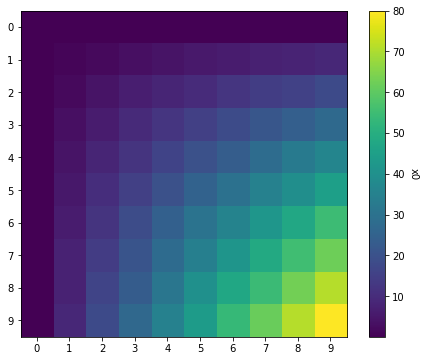

In [114]:
x_rng = (0, 10)
y_rng = (0, 10)
x_step = 1
y_step = 1
S = [1, 1]
numtrees = 100
x_ticks = (np.arange(0, 10, 1), np.arange(0, 10, 1))
y_ticks = (np.arange(0, 10, 1), np.arange(0, 10, 1))
#####meta above this point#######
t_start = time.clock()
models = forest.estimators_
num_vars = len(S)
new_grid = 0
for model in models:
    vals = traverse_all_paths(model, X, y, S, continuous_y=True)
    new_grid += new_make_grid(vals, x_rng, y_rng, x_step, y_step, S)
new_grid = new_grid/(numtrees * 1.0)
t_end = time.clock()
print("compute time", t_end - t_start)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
im = ax.imshow(new_grid)
cbar_kw = {}
cbarlabel = "x0"
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
x_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
y_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
ax.set_xticks(x_ticks[0])
ax.set_yticks(y_ticks[0])
ax.set_xticklabels(x_ticks[1])
ax.set_yticklabels(y_ticks[1])
plt.show()

In [115]:
print(old_grid - new_grid)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


compute time 39.89037600000006


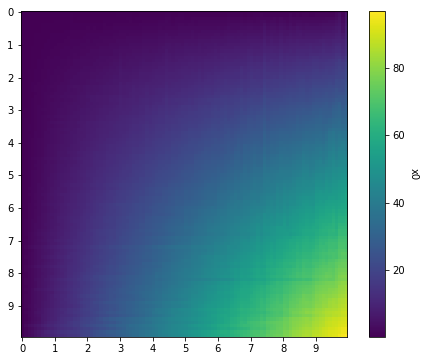

In [118]:
x_rng = (0, 10)
y_rng = (0, 10)
x_step = .1
y_step = .1
S = [1, 1]
numtrees = 100
x_ticks = (np.arange(0, 100, 10), np.arange(0, 10, 1))
y_ticks = (np.arange(0, 100, 10), np.arange(0, 10, 1))
#####meta above this point#######
t_start = time.clock()
models = forest.estimators_
num_vars = len(S)
new_grid = 0
for model in models:
    vals = traverse_all_paths(model, X, y, S, continuous_y=True)
    new_grid += new_make_grid(vals, x_rng, y_rng, x_step, y_step, S)
new_grid = new_grid/(numtrees * 1.0)
t_end = time.clock()
print("compute time", t_end - t_start)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
im = ax.imshow(new_grid)
cbar_kw = {}
cbarlabel = "x0"
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
x_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
y_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
ax.set_xticks(x_ticks[0])
ax.set_yticks(y_ticks[0])
ax.set_xticklabels(x_ticks[1])
ax.set_yticklabels(y_ticks[1])
plt.show()